LDA で分野混合の用語クラスタリングを実行する (第二部)
開発: 黒田 航 (kow.kuroda@gmail.com)

2024/03/01 に料理用語の処理を追加
2024/03/02 にskippy4gram の処理と追加 (階層クラスタリングの扱いは不十分)
2024/10/09 にmultiprocess moduleを使って，skippy4gram の生成を高速化

In [61]:
## imports
import sys, os, copy, pickle, random
import numpy as np
import pandas as pd

In [62]:
## 一般設定
verbose   = False
save_data = False

import random
random.seed(12345)

## 分野の設定
domains = { 'medical'    : True,
            'mce'        : False,
            'economic'   : True,
            'juridical'  : True,
            'publishing' : True,
            'cooking'    : False
            }

target_vars = ['word']
target_vars.extend(domains.keys())
print(f"target_vars: {target_vars}")

## 分野の選択
selected_domains = { k:v for k,v in domains.items() if v == True } # as dictionary
print(f"selected domains: {[ k for k, v in selected_domains.items() if v == True ]}")

## domain count balancing
balanced = True
print(f"domain balancing: {balanced}")

target_vars: ['word', 'medical', 'mce', 'economic', 'juridical', 'publishing', 'cooking']
selected domains: ['medical', 'economic', 'juridical', 'publishing']
domain balancing: True


In [63]:
### LDA

## n_topics
n_topics = 30

## DTM 濾過のための設定
minfreq_val         = 2
abuse_threshold_val = 0.01

## DTM 構築のための設定
## doc, term の設定
doc_type           = 'word'
term_size          = 'character'
term_types         = [ '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram', 'skippy4gram' ]
term_type          = term_types[-2]
print(f"term_type: {term_type}")
ngram_is_inclusive = True
max_doc_length     = 13

## skippy n-grams
gap_mark = "…"
max_gap_size = round(max_doc_length * 0.75)

term_type: skippy3gram


In [64]:
## 配色
colors =  [ 'deeppink', 'pink',  'orange', 'green', 'paleturquoise', 'wheat', 'gray' ]
colors_mapped = list(zip(colors, domains)) # Crucially, list(...)
colormap = { i : x[0] for i, x in enumerate(colors_mapped) if x[-1] in selected_domains }
print(colormap)
xcolormap = { i : y for i, y in enumerate(colors_mapped) if y[-1] in selected_domains }
for k, v in xcolormap.items():
    print(f"分野 id: {k}, 名称: {v[-1]}".ljust(16) + " => ".rjust(-10) + f"色: {v[0]}")

{0: 'deeppink', 2: 'orange', 3: 'green', 4: 'paleturquoise'}
分野 id: 0, 名称: medical => 色: deeppink
分野 id: 2, 名称: economic => 色: orange
分野 id: 3, 名称: juridical => 色: green
分野 id: 4, 名称: publishing => 色: paleturquoise


# データの準備

In [65]:
## 保存してあるデータの読み込み
target_dir = "saves"
files = [ f for f in os.listdir(target_dir) if f.endswith(".p") or f.endswith(".dump") ]
#print(files)
#target_file = files[-3] # selects a target file
target_file = "mixed-terms-filtered-2024-01-03-15.p" # publishing x sampled=1
print(f"target file: {target_file}")
target_file_name = os.path.join(target_dir, target_file)

target file: mixed-terms-filtered-2024-01-03-15.p


In [66]:
## Pandas を使って .csv ファイルを開くと実は面倒
#import pandas as pd
#df = pd.read_csv(target_file_name, quotechar='"') ## pandas.csv_read(..) opens a file directly
#df

In [67]:
import pandas as pd
import pickle
with open(target_file_name, 'rb') as pickled:
    df = pickle.load(pickled)
df

,word,medical,mce,economic,juridical,publishing,domain,1gram,2gram,3gram,skippy2gram,skippy3gram
727,審問,0.0,0.0,0.0,1.0,0.0,3,"[審, 問]","[審問, 審, 問]","[審問, 審問, 審, 問]","[審問, 審, 問]","[審問, 審問, 審, 問]"
332,後頭葉,1.0,0.0,0.0,0.0,0.0,0,"[後, 頭, 葉]","[後頭, 頭葉, 後, 頭, 葉]","[後頭葉, 後頭, 頭葉, 後, 頭, 葉]","[後頭, 後…葉, 頭葉, 後, 頭, 葉]","[後頭葉, 後頭, 後…葉, 頭葉, 後, 頭, 葉]"
435,ISBN,0.0,0.0,0.0,0.0,1.0,4,"[I, S, B, N]","[IS, SB, BN, I, S, B, N]","[ISB, SBN, IS, SB, BN, I, S, B, N]","[IS, I…B, I…N, SB, S…N, BN, I, S, B, N]","[ISB, IS…N, I…BN, SBN, IS, I…B, I…N, SB, S…N, ..."
1224,腸管癒着,1.0,0.0,0.0,0.0,0.0,0,"[腸, 管, 癒, 着]","[腸管, 管癒, 癒着, 腸, 管, 癒, 着]","[腸管癒, 管癒着, 腸管, 管癒, 癒着, 腸, 管, 癒, 着]","[腸管, 腸…癒, 腸…着, 管癒, 管…着, 癒着, 腸, 管, 癒, 着]","[腸管癒, 腸管…着, 腸…癒着, 管癒着, 腸管, 腸…癒, 腸…着, 管癒, 管…着, ..."
577,前方脱臼,1.0,0.0,0.0,0.0,0.0,0,"[前, 方, 脱, 臼]","[前方, 方脱, 脱臼, 前, 方, 脱, 臼]","[前方脱, 方脱臼, 前方, 方脱, 脱臼, 前, 方, 脱, 臼]","[前方, 前…脱, 前…臼, 方脱, 方…臼, 脱臼, 前, 方, 脱, 臼]","[前方脱, 前方…臼, 前…脱臼, 方脱臼, 前方, 前…脱, 前…臼, 方脱, 方…臼, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
68,婚姻届,0.0,0.0,0.0,1.0,0.0,3,"[婚, 姻, 届]","[婚姻, 姻届, 婚, 姻, 届]","[婚姻届, 婚姻, 姻届, 婚, 姻, 届]","[婚姻, 婚…届, 姻届, 婚, 姻, 届]","[婚姻届, 婚姻, 婚…届, 姻届, 婚, 姻, 届]"
103,ジャパンバッシング,0.0,0.0,1.0,0.0,0.0,2,"[ジ, ャ, パ, ン, バ, ッ, シ, ン, グ]","[ジャ, ャパ, パン, ンバ, バッ, ッシ, シン, ング, ジ, ャ, パ, ン, バ...","[ジャパ, ャパン, パンバ, ンバッ, バッシ, ッシン, シング, ジャ, ャパ, パン...","[ジャ, ジ…パ, ジ…ン, ジ…バ, ジ…ッ, ジ…シ, ジ…グ, ャパ, ャ…ン, ャ…...","[ジャパ, ジャ…ン, ジャ…バ, ジャ…ッ, ジャ…シ, ジャ…グ, ジ…パン, ジ…パ…..."
1307,胸骨挫傷,1.0,0.0,0.0,0.0,0.0,0,"[胸, 骨, 挫, 傷]","[胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]","[胸骨挫, 骨挫傷, 胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]","[胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, 挫傷, 胸, 骨, 挫, 傷]","[胸骨挫, 胸骨…傷, 胸…挫傷, 骨挫傷, 胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, ..."
2279,麻痺性歩行,1.0,0.0,0.0,0.0,0.0,0,"[麻, 痺, 性, 歩, 行]","[麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]","[麻痺性, 痺性歩, 性歩行, 麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]","[麻痺, 麻…性, 麻…歩, 麻…行, 痺性, 痺…歩, 痺…行, 性歩, 性…行, 歩行,...","[麻痺性, 麻痺…歩, 麻痺…行, 麻…性歩, 麻…性…行, 麻…歩行, 痺性歩, 痺性…行..."


In [68]:
### The following became obsolete after implementation of multiprocess-based n-gram generateion
# ## skippy 4gram を追加
# import gen_ngrams
# skippy4grams = [ gen_ngrams.gen_skippy_ngrams(x, n = 4, sep = "", max_distance = max_gap_size, check = False) for x in df['1gram'] ]

# # make ngram inclusive
# if ngram_is_inclusive:
#     for i, q in enumerate(skippy4grams):
#         q.extend(list(df['skippy3gram'])[i])
# # add column
# df['skippy4gram'] = skippy4grams
# df['skippy4gram']

In [69]:
## Set up for 'multiprocess' module if necessary
#!conda install multiprocess -y

In [70]:
def gen_ngrams_generic (u: list = None, skippy: bool = False, n_for_ngram: int = None, sep: str = "", max_distance: int = None, check: bool = False):
    "u is a list of unigrams like ['t', 'h', 'i', 'n', 'k']"
    import gen_ngrams
    if skippy:
        return gen_ngrams.gen_skippy_ngrams (u, n = n_for_ngram, sep = sep, max_distance = max_distance, check = check)
    else:
        return gen_ngrams.gen_ngrams (u, n = n_for_ngram, sep = sep, check = check)

In [71]:
## generate skippy 4gram
import functools
import multiprocess as mp

n_for_ngram = 4
params = { 'skippy' : True, 'n_for_ngram': n_for_ngram, 'sep' : "", 'max_distance' : None, 'check' : False }
gen_skippy_ngram = functools.partial(gen_ngrams_generic, **params)

#import multiprocessing as mp # This fails on IPython
unigrams = df['1gram']
with mp.Pool(max(os.cpu_count() - 1, 1)) as pool:
    skippy4grams = pool.map(gen_skippy_ngram, unigrams)

# make ngram inclusive
if ngram_is_inclusive:
    for i, g in enumerate(skippy4grams):
        g.extend(list(df['skippy3gram'])[i])
# add column
df['skippy4gram'] = skippy4grams
df['skippy4gram']

727                                  [審, 問, 審問, 審問, 審, 問]
332                  [後, 頭, 葉, 後頭葉, 後頭, 後…葉, 頭葉, 後, 頭, 葉]
435     [ISBN, ISB, IS…N, I…BN, SBN, IS, I…B, I…N, SB,...
1224    [腸管癒着, 腸管癒, 腸管…着, 腸…癒着, 管癒着, 腸管, 腸…癒, 腸…着, 管癒,...
577     [前方脱臼, 前方脱, 前方…臼, 前…脱臼, 方脱臼, 前方, 前…脱, 前…臼, 方脱,...
                              ...                        
68                   [婚, 姻, 届, 婚姻届, 婚姻, 婚…届, 姻届, 婚, 姻, 届]
103     [ジャパン, ジャパ…バ, ジャパ…ッ, ジャパ…シ, ジャパ…ン, ジャパ…グ, ジャ…ン...
1307    [胸骨挫傷, 胸骨挫, 胸骨…傷, 胸…挫傷, 骨挫傷, 胸骨, 胸…挫, 胸…傷, 骨挫,...
2279    [麻痺性歩, 麻痺性…行, 麻痺…歩行, 麻…性歩行, 痺性歩行, 麻痺性, 麻痺…歩, 麻...
154                  [買, 掛, 金, 買掛金, 買掛, 買…金, 掛金, 買, 掛, 金]
Name: skippy4gram, Length: 1997, dtype: object

In [72]:
## 列名 domain を変更し，文字列としての domain を追加
df = df.rename(columns = {'domain': 'domain_id'})
df['domain'] = [ list(domains.keys())[i] for i in df['domain_id'] ]
df[['1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram', 'skippy4gram']]

,1gram,2gram,3gram,skippy2gram,skippy3gram,skippy4gram
727,"[審, 問]","[審問, 審, 問]","[審問, 審問, 審, 問]","[審問, 審, 問]","[審問, 審問, 審, 問]","[審, 問, 審問, 審問, 審, 問]"
332,"[後, 頭, 葉]","[後頭, 頭葉, 後, 頭, 葉]","[後頭葉, 後頭, 頭葉, 後, 頭, 葉]","[後頭, 後…葉, 頭葉, 後, 頭, 葉]","[後頭葉, 後頭, 後…葉, 頭葉, 後, 頭, 葉]","[後, 頭, 葉, 後頭葉, 後頭, 後…葉, 頭葉, 後, 頭, 葉]"
435,"[I, S, B, N]","[IS, SB, BN, I, S, B, N]","[ISB, SBN, IS, SB, BN, I, S, B, N]","[IS, I…B, I…N, SB, S…N, BN, I, S, B, N]","[ISB, IS…N, I…BN, SBN, IS, I…B, I…N, SB, S…N, ...","[ISBN, ISB, IS…N, I…BN, SBN, IS, I…B, I…N, SB,..."
1224,"[腸, 管, 癒, 着]","[腸管, 管癒, 癒着, 腸, 管, 癒, 着]","[腸管癒, 管癒着, 腸管, 管癒, 癒着, 腸, 管, 癒, 着]","[腸管, 腸…癒, 腸…着, 管癒, 管…着, 癒着, 腸, 管, 癒, 着]","[腸管癒, 腸管…着, 腸…癒着, 管癒着, 腸管, 腸…癒, 腸…着, 管癒, 管…着, ...","[腸管癒着, 腸管癒, 腸管…着, 腸…癒着, 管癒着, 腸管, 腸…癒, 腸…着, 管癒,..."
577,"[前, 方, 脱, 臼]","[前方, 方脱, 脱臼, 前, 方, 脱, 臼]","[前方脱, 方脱臼, 前方, 方脱, 脱臼, 前, 方, 脱, 臼]","[前方, 前…脱, 前…臼, 方脱, 方…臼, 脱臼, 前, 方, 脱, 臼]","[前方脱, 前方…臼, 前…脱臼, 方脱臼, 前方, 前…脱, 前…臼, 方脱, 方…臼, ...","[前方脱臼, 前方脱, 前方…臼, 前…脱臼, 方脱臼, 前方, 前…脱, 前…臼, 方脱,..."
...,...,...,...,...,...,...
68,"[婚, 姻, 届]","[婚姻, 姻届, 婚, 姻, 届]","[婚姻届, 婚姻, 姻届, 婚, 姻, 届]","[婚姻, 婚…届, 姻届, 婚, 姻, 届]","[婚姻届, 婚姻, 婚…届, 姻届, 婚, 姻, 届]","[婚, 姻, 届, 婚姻届, 婚姻, 婚…届, 姻届, 婚, 姻, 届]"
103,"[ジ, ャ, パ, ン, バ, ッ, シ, ン, グ]","[ジャ, ャパ, パン, ンバ, バッ, ッシ, シン, ング, ジ, ャ, パ, ン, バ...","[ジャパ, ャパン, パンバ, ンバッ, バッシ, ッシン, シング, ジャ, ャパ, パン...","[ジャ, ジ…パ, ジ…ン, ジ…バ, ジ…ッ, ジ…シ, ジ…グ, ャパ, ャ…ン, ャ…...","[ジャパ, ジャ…ン, ジャ…バ, ジャ…ッ, ジャ…シ, ジャ…グ, ジ…パン, ジ…パ…...","[ジャパン, ジャパ…バ, ジャパ…ッ, ジャパ…シ, ジャパ…ン, ジャパ…グ, ジャ…ン..."
1307,"[胸, 骨, 挫, 傷]","[胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]","[胸骨挫, 骨挫傷, 胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]","[胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, 挫傷, 胸, 骨, 挫, 傷]","[胸骨挫, 胸骨…傷, 胸…挫傷, 骨挫傷, 胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, ...","[胸骨挫傷, 胸骨挫, 胸骨…傷, 胸…挫傷, 骨挫傷, 胸骨, 胸…挫, 胸…傷, 骨挫,..."
2279,"[麻, 痺, 性, 歩, 行]","[麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]","[麻痺性, 痺性歩, 性歩行, 麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]","[麻痺, 麻…性, 麻…歩, 麻…行, 痺性, 痺…歩, 痺…行, 性歩, 性…行, 歩行,...","[麻痺性, 麻痺…歩, 麻痺…行, 麻…性歩, 麻…性…行, 麻…歩行, 痺性歩, 痺性…行...","[麻痺性歩, 麻痺性…行, 麻痺…歩行, 麻…性歩行, 痺性歩行, 麻痺性, 麻痺…歩, 麻..."


In [74]:
## diction = dtm を構築
from gensim.corpora.dictionary import Dictionary
bots = df[term_type] # bot = bag-of-terms
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<40700 unique tokens: ['問', '審', '審問', '後', '後…葉']...>


In [75]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction) # 予備の生成
## 対象とする語の最低頻度: documents の数が少ない場合は小さくても良い
print(f"minfreq_val: {minfreq_val}")
## 過剰使用 term の濾過
print(f"abuse_threshold_val: {abuse_threshold_val}")
## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = minfreq_val, no_above = abuse_threshold_val)
## check
print(diction_copy) # 中身を見るには print(..) が必要

minfreq_val: 2
abuse_threshold_val: 0.01
Dictionary<8354 unique tokens: ['問', '審', '審問', '後…葉', '後頭']...>


In [76]:
### gensim の用 corpusの構築
diction = diction_copy # 名前を元に戻す
## corpus構築
corpus = [ diction.doc2bow(bot) for bot in bots ]
print(f"Number of documents: {len(corpus)}")

Number of documents: 1997


In [77]:
## LDA モデルの構築
from gensim.models import LdaModel
## LDAモデル
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(lda) # 中身を見るには print(..) が必要

LdaModel<num_terms=8354, num_topics=30, decay=0.5, chunksize=2000>


pyLDAvis を使った term-topic 関連性の可視化

In [78]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"pyLDAvis installed version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター
use_MMDS = False
use_tSNE = False
if use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds', n_jobs = 1, sort_topics = False)
elif use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne', n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## 結果について
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [79]:
%%capture --no-display

## lda のtopic ごとに，関連度の高い term を表示
import pandas as pd

n_terms = 30 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,...,topic 21,topic 22,topic 23,topic 24,topic 25,topic 26,topic 27,topic 28,topic 29,topic 30
0,刻印,同,綴,時,捜索,得喪,働,裁判,保釈,関,...,訴,財産,養親,T,用,聴,クロ,連,広報,投資
1,挫,B,じ,結核,O,ラ…ン,労働,キ,皮,針金,...,員,ライ,請,処,親,意,原稿,質,P,ュ
2,腎,共,綴じ,核,廷,ライ,労,ング,に,黄,...,染,財,養,結核,用紙,E,ク…経,ル…ー,管理,化
3,貨,議,投資,睡,調,陰,的,ン…ス,運,帯,...,判…裁判,開,指輪,出血,養親,丁合,ロ経,再,時,投
4,熱,共同,投,眠,スト,角,子,移,毒,疸,...,員…判,束,断,結…性,代,議,ロ経済,日,ペ,デ
5,耳,解,ッ…フ,睡眠,法…通,イ…ー,議,質,運動,性…症,...,少,面,断裁,状,調,ッ…ー,ク…経済,ダ,判決,政
6,銀行,書,排,添人,和解,イム,遺棄,転移,基,骨,...,表紙,腺,原,核,市場,ウ,クロ経,ネ,報,渡
7,印,痺,D,組,音,慢…腎,刷,転,中毒,肝,...,訴状,見,求,上場,市,見…取,束,金融,広,新
8,時,下,保険,新,一般,腎,延焼,ャ…ング,い,黄疸,...,判員裁,ー…プ,審,ラン,場,見聴,懲役,融,天…内,オ
9,挫傷,協,1,解,法廷…人,慢,セ,ッシ…グ,刑,ット,...,員裁判,グラ,請求,う,レー,標,ロ…済,代,先天,預金


Documents のエンコード

In [80]:
## documents のエンコード
check = False
encoding = [ ]
print(f"get encodings using term_type: {term_type}")
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

get encodings using term_type: skippy3gram


1997

In [81]:
## df に encoding の列を追加: tuple なので map(..) が必要
df['enc'] = [ list(map(lambda x: x[1], enc)) for enc in encoding ]
if check:
    df

# t-SNE を使った可視化

In [82]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)
import sklearn.manifold
import numpy as np
import pandas as pd
import plotly.express as pex

## perplexity の効果を確認
divider = 5
relative_perplexity = True
if relative_perplexity:
    max_val = round(len(df)/divider)
else:
    max_val = 200
perplexity_vals = range(5, max_val, 50) # 10から始めて doc数の 1/divider まで，50づつ大きくする
print(f"perplexity vals: {perplexity_vals}")

E = np.array(list(df['enc']))
max_steps = 3
early_stop = True
for i, perplexity_val in enumerate(perplexity_vals):
    ## 早期停止
    if early_stop:
        if i >= max_steps:
            continue
    ## tSNE 3D の生成
    tSNE_3d_varied = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                perplexity = perplexity_val, n_iter = 1000)
    ## Fitting
    fit_3d = tSNE_3d_varied.fit_transform(E)
    
    ## df の編集
    df['D1'] = fit_3d[:,0]
    df['D2'] = fit_3d[:,1]
    df['D3'] = fit_3d[:,2]
    
    ## 描画
    title_val = f"t-SNE 3D map (ppl: {perplexity_val}) for encodings via {term_type}-based LDA ({n_topics} topics)"
    fig = pex.scatter_3d(df, x = 'D1', y = 'D2', z = 'D3', color = 'domain', title = title_val)
    #
    fig.update_layout(showlegend = True, legend = {'itemsizing': 'constant'},
                  autosize = False, width = 600, height = 600)
    fig.update_traces(marker_size = 5)
    fig.show()
#

# 階層クラスタリング

In [83]:
## 階層クラスタリングのための事例サンプリング

import os, pickle

## データの再利用のための設定
target_dir = "saves"
signature  = "hc-df-sampled-"
        
## サンプリング処理

reload_df_sampled = True
save_a_new_df     = False # データを更新する時に True にする

## df-sampled.p の最新の版を選ぶ
target_p_fname = [ f for f in [ f for f in os.listdir(target_dir)
                               if signature in str(f) ] if f.endswith(".p") or f.endswith(".dump") ][-1]
print(f"target_p_fname: {target_p_fname}")

target_p_fpath = os.path.join(target_dir, target_p_fname)
with open(target_p_fpath, 'rb') as data:
    print(f"loading pickle: {target_p_fpath}")
    df_sampled_reloaded = pickle.load(data)

##
df_size = len(df)
hc_sampling_rate = 0.1 # 変更可能: 大きくし過ぎると図が見にくい

if reload_df_sampled:
    df_sampled = df_sampled_reloaded
else:
    df_sampled = df.sample(round(df_size * hc_sampling_rate))
    ## 保存
    if save_a_new_df:
        import datetime as dt
        ct = dt.datetime.now()
        ## Pandas で .csv として
        hc_sample_fn1 = f"{target_dir}/{signature}{ct.date()}-{str(ct.time())[:2]}" + ".csv"
        ## pickle を .p として
        hc_sample_fn2 = f"{target_dir}/{signature}{ct.date()}-{str(ct.time())[:2]}" + ".p"

        ## reload 用に保存
        import pandas as pd
        df_sampled.to_csv(hc_sample_fn1)
        print(f"saving data to {hc_sample_fn1}")

        ## pickle.dump(..)で
        import pickle
        print(f"saving data to {hc_sample_fn2}")
        with open(hc_sample_fn2, "wb") as f:
            pickle.dump(df_sampled, f)

##
print(f"{len(df_sampled)} rows are sampled (preservation rate: {len(df_sampled)/df_size})")

## domain 事例数の確認
df_sampled['domain'].value_counts()

target_p_fname: hc-df-sampled-2024-01-08-18.p
loading pickle: saves/hc-df-sampled-2024-01-08-18.p
200 rows are sampled (preservation rate: 0.100150225338007)


domain
juridical     55
publishing    53
medical       52
economic      40
Name: count, dtype: int64

In [84]:
df_sampled.columns

Index(['word', 'medical', 'mce', 'economic', 'juridical', 'publishing',
       'domain_id', '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram',
       'domain', 'enc', 'tSNE_dim1', 'tSNE_dim2', 'tSNE_dim3', 'tSNE_d1',
       'tSNE_d2', 'tSNE_d3'],
      dtype='object')

In [85]:
# df_sampled['enc'] の再エンコード
check = False
re_encoding = [ ]
print(f"get encodings using term_type: {term_type}")
for i, row in df_sampled.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    re_encoding.append(enc)
#
len(re_encoding)

get encodings using term_type: skippy3gram


200

In [86]:
## 値の更新
check = False
df_sampled['enc'] = [ enc[-1] for enc in re_encoding ]
if check:
    df_sampled

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47556/1031925965.py:33: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



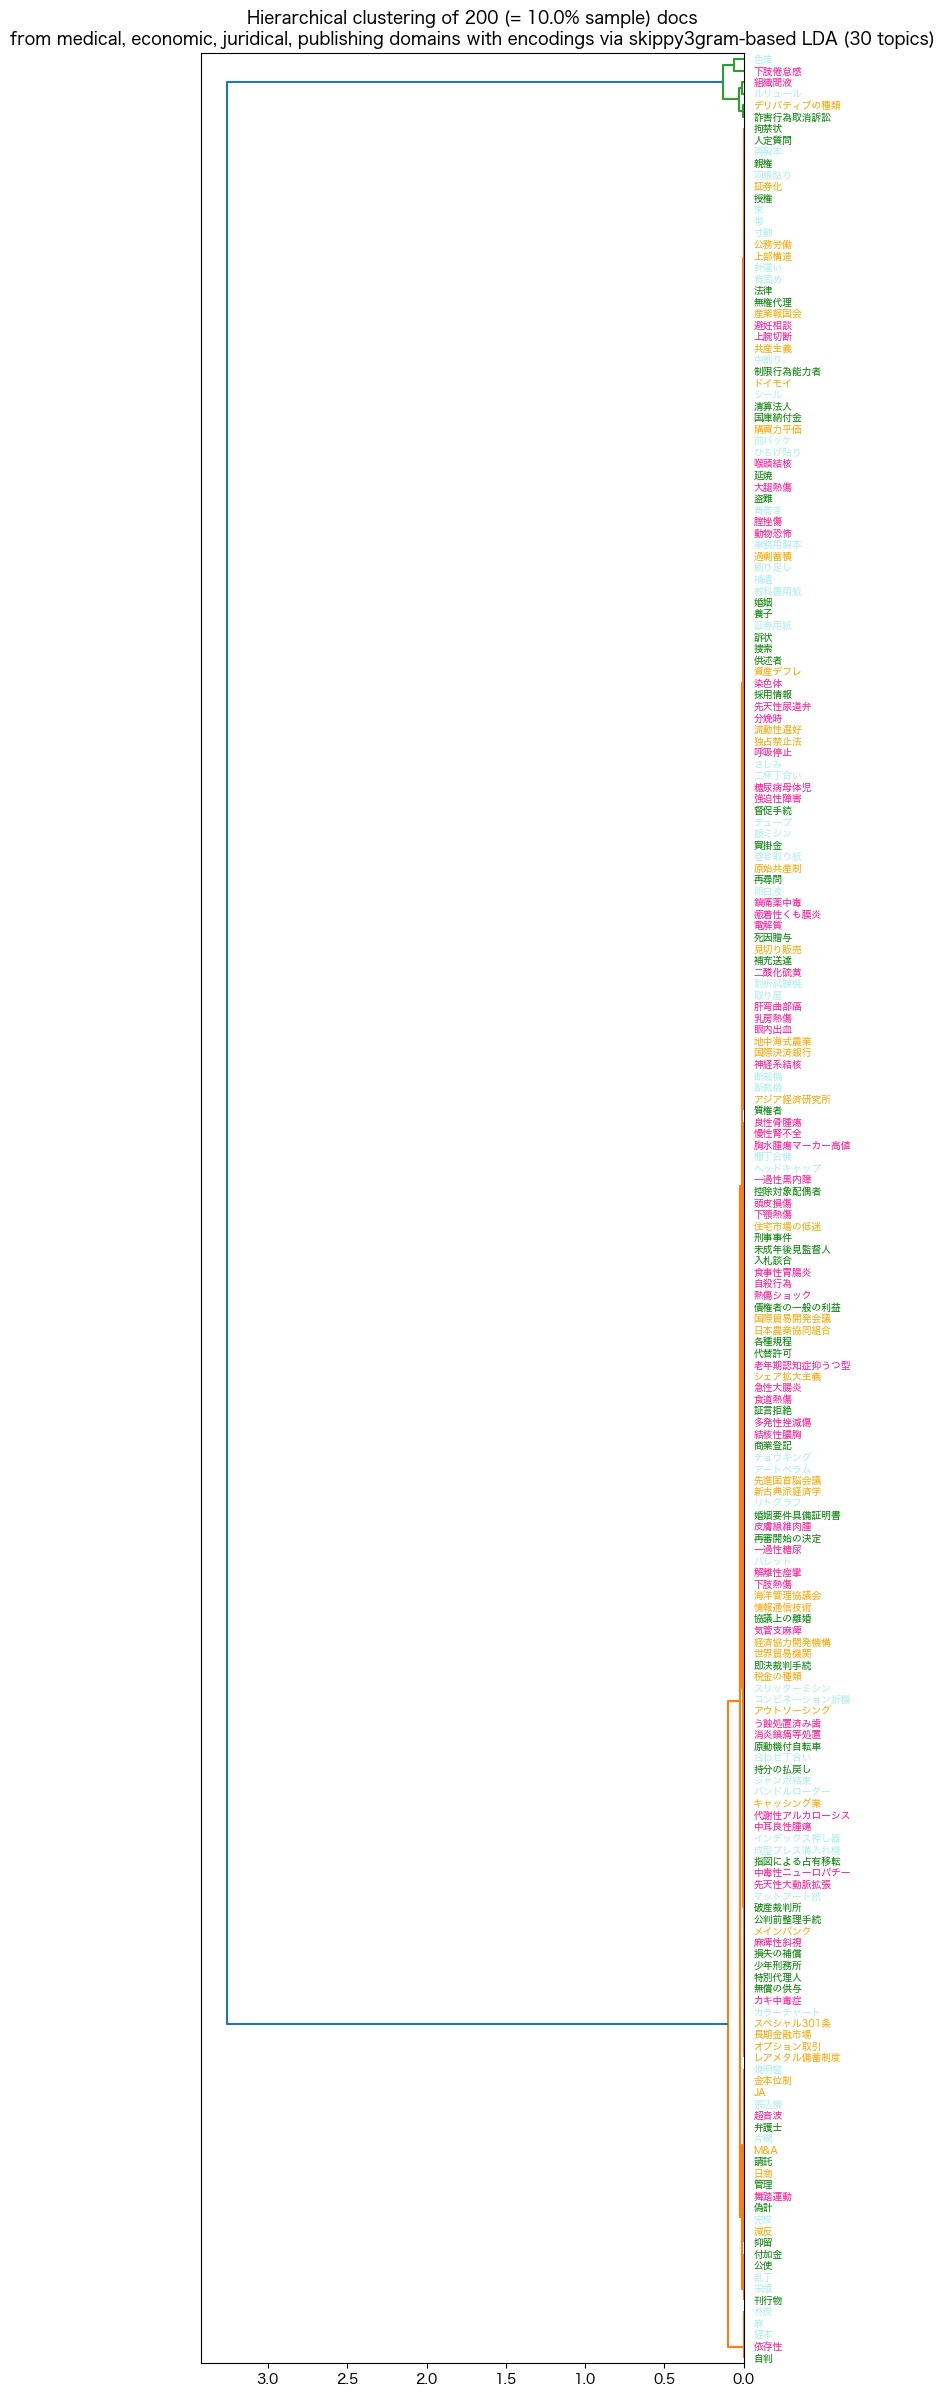

In [87]:
## doc 階層クラスタリングの実行
import numpy as np
import plotly
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Hiragino sans" # 日本語表示のための設定

## 距離行列の生成
from scipy.cluster.hierarchy import dendrogram, linkage
doc_linkage_plain = linkage(list(df_sampled['enc']), method = 'ward', metric = 'euclidean')

## 描画サイズの指定
plt.figure(figsize = (7, round(10 * len(df_sampled) * 0.015))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_length] for x in list(df_sampled[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
dendrogram(doc_linkage_plain, orientation = 'left', labels = label_vals, leaf_font_size = 7)
plt.title(f"Hierarchical clustering of {len(df_sampled)} (= {100 * hc_sampling_rate}% sample) docs\n\
from {', '.join(selected_domains.keys())} domains with encodings via {term_type}-based LDA ({n_topics} topics)")

## ラベルに domain に対応する色を付ける
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    word = ticker.get_text()
    matched_rows = df_sampled.loc[df_sampled[doc_type] == word]
    if len(matched_rows) == 1:
        row = matched_rows
    else:
        row = matched_rows.iloc[0] # matched_rows[0] fails to work
    ## extract domain_id value
    try:
        domain_id = int(row['domain_id'])
        ticker.set_color(colormap[domain_id]) # id の基数調整
    except TypeError:
        pass
#
plt.show()